In [1]:
import fasttext
import json
from faq50_adapted import FAQ, extract_word_probs
from topic_word_probs import *
from tfidf_classifier import TFIDF_Classifier

%load_ext autoreload
%autoreload 2

In [2]:
model_path = "models/cc.cs.300.bin"
model = fasttext.load_model(model_path)

### Tests:

In [21]:
count_word_probs_in_questions()
probs_path = "upv_faq/Q78_question_word_probs.json"
with open(probs_path, "r") as wp_file:
    probs = json.load(wp_file)
print(dict(sorted(probs.items(), key=lambda item: item[1])))

{'vztahovat': 0.00012390038409119069, 'díl': 0.00012390038409119069, 'autorův': 0.00012390038409119069, 'legální': 0.00012390038409119069, 'starost': 0.00012390038409119069, 'omezený': 0.00012390038409119069, 'porušit': 0.00012390038409119069, 'doručených': 0.00012390038409119069, 'orgán': 0.00012390038409119069, 'vyřešit': 0.00012390038409119069, 'reakce': 0.00012390038409119069, 'zveřejňován': 0.00012390038409119069, 'obsáhnout': 0.00012390038409119069, 'publikovat': 0.00012390038409119069, 'verze': 0.00012390038409119069, 'starý': 0.00012390038409119069, 'výňatky': 0.00012390038409119069, 'zněný': 0.00012390038409119069, 'kontakt': 0.00012390038409119069, 'kompetentní': 0.00012390038409119069, 'institut': 0.00012390038409119069, 'přihláškovým': 0.00012390038409119069, 'specializované': 0.00012390038409119069, 'platforma': 0.00012390038409119069, 'pokládat': 0.00012390038409119069, 'zaměstnanec': 0.00012390038409119069, 'och': 0.00012390038409119069, 'nabytí': 0.00012390038409119069,

In [22]:
q_xslx = "upv_faq/Q78_questions.xlsx"
a_xslx = "upv_faq/Q78_answers.xlsx"

faq = FAQ(model, q_xslx, a_xslx, probs=probs, alpha=0.03)

In [23]:
acc, cm = faq.cross_match_test()
print(f"\nQuestion Cross-Match Accuracy: {acc}")
acc, cm = faq.mean_match_test()
print(f"\nQuestion Mean-Match Accuracy: {acc}")


Question Cross-Match Accuracy: 0.4289340101522843

Question Mean-Match Accuracy: 0.7093908629441624


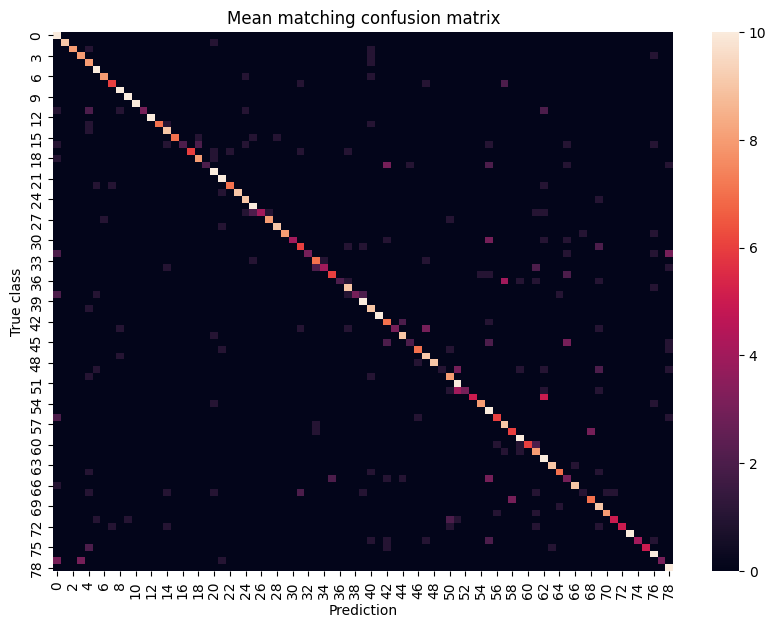

In [ ]:
m_acc, _ = faq.mean_match_test(show_cm=True)

## Confused sentences:

In [ ]:
# Ambiguous matches
path_to_save = "780_upv_questions/same_question_different_answers.json"
faq.get_same_question_different_answer_pairs(save_path=path_to_save)

{'Jaké jsou možnosti podání přihlášky průmyslového vzoru? ': ['51', '49'],
 'Kdo může podat přihlášku průmyslového vzoru?': ['52', '49'],
 'Kdo může podat přihlášku užitného vzoru?': ['61', '59'],
 'Jak mohu objednat rešeršní služby Úřadu?': ['65', '45'],
 'Jak dlouho trvá zpracování rešerše?': ['65', '45', '74'],
 'Co znamená kvalifikované zveřejnění technického řešení?': ['68', '58'],
 'Jakým způsobem lze podat objednávku na rešeršní službu?': ['74', '55']}

In [ ]:
faq.get_most_confused_questions(cos_sim_threshold=0.85) # with mean-match

(788, 79)
(788,)
40     Kde najdu právní předpisy týkající se ochrany ...
41     Na jaké stránce jsou uvedeny nejdůležitější pr...
42     Jaké právní předpisy jsou dostupné na stránkác...
399    Kde mohu najít právní předpisy týkající se pop...
400    Jaké jsou nejdůležitější právní předpisy týkaj...
402    Jaké předpisy se týkají poplatků na Úřadu prům...
403    Kde najdu předpisy týkající se poplatků při ří...
407    Jaké právní předpisy upravují poplatky na Úřad...
Name: question, dtype: object


In [ ]:
path_to_save = "780_upv_questions/most_missclassified_class_pairs"
faq.get_most_misclassified_class_pairs(n_of_common_misses=3, save_path=path_to_save)

(19, 78) 3
(19, 55) 3
(29, 78) 3
(30, 55) 3
(31, 69) 3
(34, 33) 5
(36, 57) 5
(43, 47) 3
(45, 55) 3
(49, 59) 3
(53, 62) 4
(54, 76) 3
(58, 68) 3
(64, 40) 4
(65, 55) 3
(77, 21) 3
['19:78', '19:55', '29:78', '30:55', '31:69', '34:33', '36:57', '43:47', '45:55', '49:59', '53:62', '54:76', '58:68', '64:40', '65:55', '77:21']


In [ ]:
questions_xlsx = "780_upv_questions/expanded_data_all2.xlsx"
# questions_xlsx = "upv_faq/Q50_questions.xlsx"
c = TFIDF_Classifier(questions_xlsx)

In [ ]:
test_data = c.structure_data(test_data_percent=0.1) 

c.get_TFIDF_matrix()

TFIDF matrix shape: (79, 812)


In [ ]:
c.classify_sentence("Co by nastalo kdyby patent byl zrušen?")

73

In [ ]:
c.classify_test_sentences_list(test_data)

Got right: 0.5


In [ ]:
test_data = c.structure_data(test_data_percent=1) # without removal from train data
c.get_TFIDF_matrix()
c.classify_test_sentences_list(test_data)

TFIDF matrix shape: (79, 848)
Got right: 0.8439086294416244
